#Neural Network Model for House Prices

##Competition Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

##Goal
For each Id in the test set, you must predict the value of the SalePrice variable.

##Metric
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

Our data is composed to 1460 row with 81 features. 38 continuous features and 43 categorical features.

In [29]:
import tensorflow as tf
import os
import keras

In [30]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

train = pd.read_csv("train.csv")
print('Shape of the train data with all features:', train.shape)
train = train.select_dtypes(exclude=['object'])
print("")
print('Shape of the train data with numerical features:', train.shape)
train.drop('Id',axis = 1, inplace = True)
train.fillna(0,inplace=True)

test = pd.read_csv("test.csv")
test = test.select_dtypes(exclude=['object'])
ID = test.Id
test.fillna(0,inplace=True)
test.drop('Id',axis = 1, inplace = True)

print("")
print("List of features contained our dataset:",list(train.columns))

Shape of the train data with all features: (1460, 81)

Shape of the train data with numerical features: (1460, 38)

List of features contained our dataset: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


##Isolation of outliers with an Isolation Forest

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

In [31]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 146
Number of rows without outliers: 1314


In [32]:
train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


Preprocessing

Rescaling the data using the Scikit function of MinMax Scaler

In [33]:
import warnings
warnings.filterwarnings('ignore')

col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove('SalePrice')

mat_train = np.matrix(train)
mat_test  = np.matrix(test)
mat_new = np.matrix(train.drop('SalePrice',axis = 1))
mat_y = np.array(train.SalePrice).reshape((1314,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.235294,0.207668,0.062802,0.625,0.428571,0.953488,0.883333,0.12250,0.416274,0.0,...,0.000000,0.167582,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,0.403057
1,0.000000,0.255591,0.072904,0.500,0.857143,0.744186,0.433333,0.00000,0.576651,0.0,...,0.404891,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,0.340220
2,0.235294,0.217252,0.087396,0.625,0.428571,0.937984,0.866667,0.10125,0.286557,0.0,...,0.000000,0.115385,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,0.437966
3,0.294118,0.191693,0.072464,0.625,0.428571,0.271318,0.333333,0.00000,0.127358,0.0,...,0.000000,0.096154,0.824242,0.0,0.0,0.0,0.0,0.090909,0.00,0.243639
4,0.235294,0.268371,0.113835,0.750,0.428571,0.930233,0.833333,0.21875,0.386203,0.0,...,0.260870,0.230769,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,0.499638


In [34]:
# List of features
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "SalePrice"

# Columns
feature_cols = FEATURES

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS]
prediction_set = train.SalePrice

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)
training_set.head()

# Training for submission
training_sub = training_set[col_train]

In [35]:
# Same thing but for the test set
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)
testing_set.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
1232,0.235294,0.239617,0.074221,0.625,0.571429,0.914729,0.800000,0.00000,0.574882,0.0,...,0.343750,0.467033,0.0,0.0,0.0,0.0,0.000000,0.454545,0.00,0.556191
76,0.352941,0.000000,0.063505,0.625,0.428571,0.891473,0.766667,0.01375,0.000000,0.0,...,0.163043,0.197802,0.0,0.0,0.0,0.0,0.045161,0.363636,0.75,0.309966
962,0.235294,0.249201,0.091349,0.500,0.571429,0.682171,0.300000,0.00000,0.175708,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.363636,0.75,0.276221
433,0.294118,0.159744,0.010540,0.625,0.857143,0.271318,0.916667,0.00000,0.176297,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.454545,0.75,0.278548
1110,0.294118,0.306709,0.103927,0.375,0.428571,0.263566,0.000000,0.00000,0.000000,0.0,...,0.275815,0.109890,0.0,0.0,0.0,0.0,0.000000,0.545455,0.00,0.241049


##Deep Neural Network for continuous features

Implementation of a 5-layer MLP with ReLU and L1 Regularizer
L1 Regularizer was used to address overfitting.

In our case, Adadelta was used for optimizer.



Different optimizers were tested in training the model. RMSprop, adagrad, adadelta, and SGD all fail to improve the loss after reaching a certain value (around 0.18). 

The best optimizer for this case were Adam and adadelta. It converges faster with a smaller number of epochs compared to other optimizers until a value of 0.0038.

300 epochs were used with a batch size of 10.

In [36]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.regularizers import l1



In [37]:
seed = 7
np.random.seed(seed)
kernel_regularizer = l1(0.0001)
# Model
model = Sequential()
model.add(Dense(200, input_dim=36, kernel_regularizer=kernel_regularizer, activation='relu'))
model.add(Dense(100, kernel_regularizer=kernel_regularizer, activation='relu'))
model.add(Dense(50, kernel_regularizer=kernel_regularizer, activation='relu'))
model.add(Dense(25, kernel_regularizer=kernel_regularizer, activation='relu'))
model.add(Dense(1, kernel_regularizer=kernel_regularizer))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 200)               7400      
_________________________________________________________________
dense_12 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_14 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 26        
Total params: 33,851
Trainable params: 33,851
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Compile model
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adadelta())
feature_cols = training_set[FEATURES]
labels = training_set[LABEL].values

model.fit(np.array(feature_cols), np.array(labels), epochs=300, batch_size=10)

Epoch 1/300
880/880 [==============================] - 0s 471us/step - loss: 0.2669
Epoch 2/300
880/880 [==============================] - 0s 286us/step - loss: 0.2382
Epoch 3/300
880/880 [==============================] - 0s 286us/step - loss: 0.2142
Epoch 4/300
880/880 [==============================] - 0s 284us/step - loss: 0.1916
Epoch 5/300
880/880 [==============================] - 0s 283us/step - loss: 0.1701
Epoch 6/300
880/880 [==============================] - 0s 284us/step - loss: 0.1494
Epoch 7/300
880/880 [==============================] - 0s 282us/step - loss: 0.1309
Epoch 8/300
880/880 [==============================] - 0s 282us/step - loss: 0.1139
Epoch 9/300
880/880 [==============================] - 0s 281us/step - loss: 0.0971
Epoch 10/300
880/880 [==============================] - 0s 283us/step - loss: 0.0830
Epoch 11/300
880/880 [==============================] - 0s 287us/step - loss: 0.0704
Epoch 12/300
880/880 [==============================] - 0s 280us/step - lo

880/880 [==============================] - 0s 281us/step - loss: 0.0038
Epoch 191/300
880/880 [==============================] - 0s 281us/step - loss: 0.0037
Epoch 192/300
880/880 [==============================] - 0s 278us/step - loss: 0.0037
Epoch 193/300
880/880 [==============================] - 0s 280us/step - loss: 0.0038
Epoch 194/300
880/880 [==============================] - 0s 283us/step - loss: 0.0038
Epoch 195/300
880/880 [==============================] - 0s 280us/step - loss: 0.0037
Epoch 196/300
880/880 [==============================] - 0s 281us/step - loss: 0.0037
Epoch 197/300
880/880 [==============================] - 0s 277us/step - loss: 0.0037
Epoch 198/300
880/880 [==============================] - 0s 275us/step - loss: 0.0038
Epoch 199/300
880/880 [==============================] - 1s 983us/step - loss: 0.0037
Epoch 200/300
880/880 [==============================] - 1s 754us/step - loss: 0.0038
Epoch 201/300
880/880 [==============================] - 1s 813us/st

In [39]:
# Evaluation on the test set created by train_test_split
model.evaluate(np.array(feature_cols), np.array(labels))

880/880 [==============================] - 0s 260us/step


0.0036539446223865855

In [40]:
# Predictions
feature_cols_test = testing_set[FEATURES]
labels_test = testing_set[LABEL].values

y = model.predict(np.array(feature_cols_test))
predictions = list(itertools.islice(y, testing_set.shape[0]))

In [41]:
y_predict = model.predict(np.array(test))

def to_submit(pred_y,name_out):
    y_predict = list(itertools.islice(pred_y, test.shape[0]))
    y_predict = pd.DataFrame(prepro_y.inverse_transform(np.array(y_predict).reshape(len(y_predict),1)), columns = ['SalePrice'])
    y_predict = y_predict.join(ID)
    y_predict.to_csv(name_out + '.csv',index=False)
    
to_submit(y_predict, "submit_prediction_new")

For each Id in the test set, we predicted the value of the SalePrice variable.

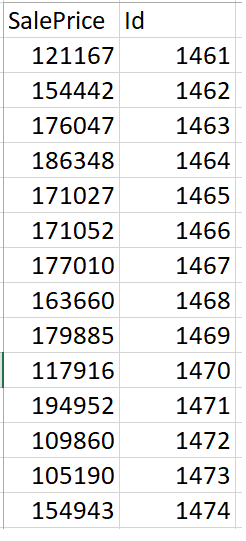

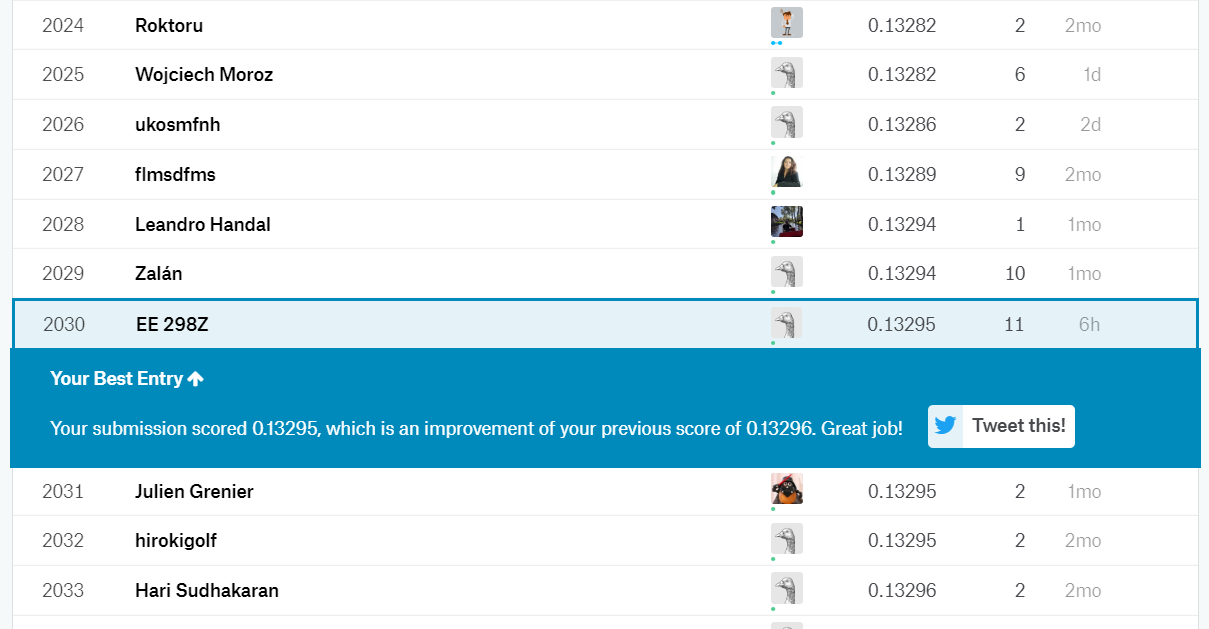

As of October 19, 2019, our team submission scored 0.13295 which ranked 2030th out of 4782 teams (top 42%). 